In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

In [4]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [5]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [6]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [7]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline




Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[REDUCED_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[REDUCED_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[REDUCED_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[REDUCED_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values

X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


In [8]:
print(X_train_balanced.shape, X_test_balanced.shape)
print(X_train_imbalanced.shape, X_test_imbalanced.shape)

(1750, 11) (430, 11)
(7188, 11) (1797, 11)


In [9]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    842
1.0    558
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    208
1.0    142
dtype: int64
0.0    1305
1.0     133
dtype: int64


In [10]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score
from imblearn.metrics import specificity_score


# Create a custom scorer for use in GridSearchCV or RFECV
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)


# Define a custom scoring function
def custom_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # Weight recall more heavily
    return 0.8 * recall + 0.2 * accuracy

custom_scorer = make_scorer(custom_score, greater_is_better=True)


def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    # print(f"{label} Balanced Accuracy:", balanced_accuracy_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))
    # print(f"{label} F2 Score:", fbeta_score(real, pred, beta=2))
    # print(f"{label} Custom Scorer:", custom_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Random Forest Classifier

Selected Features: [False False  True False  True False  True  True False  True  True]
Feature Ranking: [6 2 1 5 1 4 1 1 3 1 1]
real_positives = 558.0, total = 1400
Balanced train Accuracy: 0.8071428571428572
Balanced train Precision: 0.8302752293577982
Balanced train Recall: 0.6487455197132617
Balanced train Specificity: 0.9121140142517815
Balanced train F1 Score: 0.7283702213279678


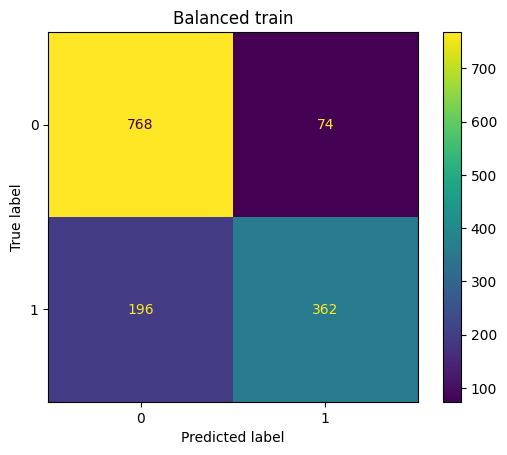

real_positives = 142.0, total = 350
Balanced test Accuracy: 0.7457142857142857
Balanced test Precision: 0.7304347826086957
Balanced test Recall: 0.5915492957746479
Balanced test Specificity: 0.8509615384615384
Balanced test F1 Score: 0.6536964980544747


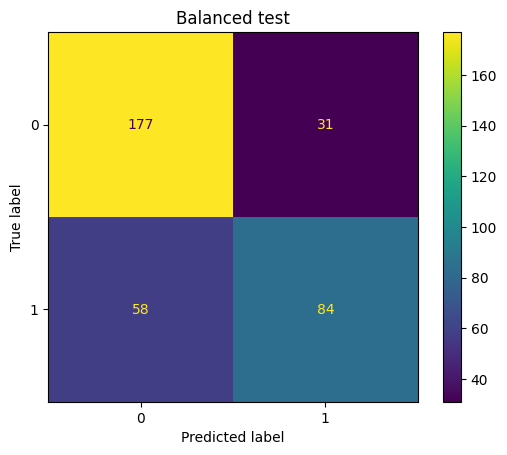

real_positives = 133.0, total = 1438
Imbalanced test Accuracy: 0.8567454798331016
Imbalanced test Precision: 0.35797665369649806
Imbalanced test Recall: 0.6917293233082706
Imbalanced test Specificity: 0.8735632183908046
Imbalanced test F1 Score: 0.47179487179487173


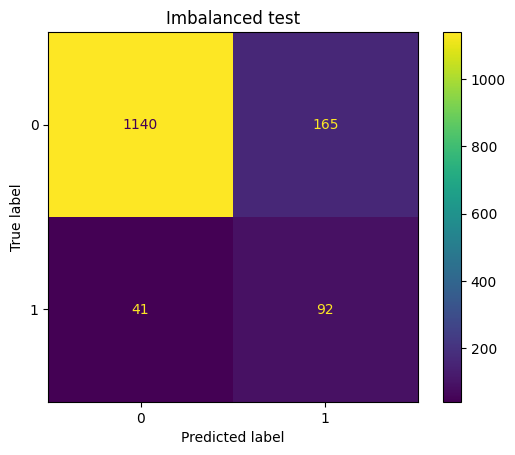

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf = (RandomForestClassifier(
    random_state=13,
    max_depth=  6,
    max_features= 'sqrt',
    min_samples_leaf= 6,
    min_samples_split= 10,
    n_estimators= 80))

# Create RFECV object with Random Forest as the estimator
rf_rfe = RFECV(estimator=rf, step=1, cv=5, scoring='f1')

# Fit RFECV
rf_rfe.fit(X_train_balanced, y_train_balanced)

# Transform the data
X_train_selected = rf_rfe.transform(X_train_valid_balanced)
X_valid_selected = rf_rfe.transform(X_valid_valid_imbalanced)
X_valid_selected_balanced = rf_rfe.transform(X_valid_valid_balanced)

# Train a new classifier using only selected features
rf_final = (RandomForestClassifier(
    random_state=42,
    max_depth=  6,
    max_features= 'sqrt',
    min_samples_leaf= 6,
    min_samples_split= 10,
    n_estimators= 80))


rf_final.fit(X_train_selected, y_train_valid_balanced)

# Predict and calculate accuracy
y_pred = rf_final.predict(X_valid_selected)
y_pred_balanced = rf_final.predict(X_valid_selected_balanced)
y_pred_train = rf_final.predict(X_train_selected)

print("Selected Features:", rf_rfe.support_)
print("Feature Ranking:", rf_rfe.ranking_)


eval(y_train_valid_balanced, y_pred_train, 'Balanced train')
eval(y_valid_valid_balanced, y_pred_balanced, 'Balanced test')
eval(y_valid_valid_imbalanced, y_pred, 'Imbalanced test')

In [12]:
display(pd.DataFrame(zip((REDUCED_FEATURE_SET), rf_rfe.support_, rf_rfe.ranking_), columns=['feature', 'include', 'ranking']).sort_values(by='ranking', ascending=True))

FINAL_FEATURE_SET = list(pd.DataFrame(zip((REDUCED_FEATURE_SET), rf_rfe.support_, rf_rfe.ranking_), columns=['feature', 'include', 'ranking']).query('ranking <= 2')['feature'])
print(FINAL_FEATURE_SET)

,feature,include,ranking
2,EQ_TA,True,1
4,LTC_NCA,True,1
6,CF_TL,True,1
7,CL_TA,True,1
9,ROA,True,1
10,ROE,True,1
1,L3,False,2
8,ROS,False,3
5,TZ,False,4
3,CL_CC,False,5


['L3', 'EQ_TA', 'LTC_NCA', 'CF_TL', 'CL_TA', 'ROA', 'ROE']


In [13]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train_valid_imbalanced and y_train_valid_imbalanced are already defined
# Count the number of samples in each class
counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

# Calculate the number of samples needed for the majority class (class 0) to achieve a 3:2 ratio
minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

# Apply RandomUnderSampler with the defined sampling strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [14]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_balanced).value_counts())
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    850
1.0    567
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    208
1.0    142
dtype: int64
0.0    1305
1.0     133
dtype: int64


In [15]:
from sklearn.model_selection import GridSearchCV

In [ ]:

# first generation
param_grid = {
    'n_estimators': [20, 30, 40, 50, 80, 100],
    'max_depth': [None, 5, 10, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 10, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}


# second generation
# param_grid = {'max_depth': [None, 20, 25, 30],
#  'max_features': ['log2', 'sqrt'],
#  'min_samples_leaf': [2, 1, 3],
#  'min_samples_split': [20, 30, 40, 50, 60],
#  'n_estimators': [100, 80, 30, 50]}

# third generation
# param_grid = {'max_depth': [20],
#  'max_features': ['sqrt'],
#  'min_samples_leaf': [1],
#  'min_samples_split': [20, 30, 60],
#  'n_estimators': [30, 40, 50] }


rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [None, 5, 10, 20, 25, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 10, 30],
                         'min_samples_split': [2, 5, 10, 20, 50],
                         'n_estimators': [20, 30, 40, 50, 80, 100]},
             scoring='f1', verbose=10)

In [ ]:
grid_search.best_params_

{'max_depth': 30,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 50,
 'n_estimators': 50}

In [ ]:
# Extract grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Sort by rank to see the best combinations first
sorted_cv_results = cv_results.sort_values(by='rank_test_score')
sorted_cv_results.head(40)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2607,0.240332,0.005212,0.012270,0.001573,30,log2,2,50,50,"{'max_depth': 30, 'max_features': 'log2', 'min...",0.714286,0.684615,0.646388,0.684015,0.734082,0.692677,0.029880,1
2125,0.155457,0.004392,0.009176,0.001934,25,log2,1,50,30,"{'max_depth': 25, 'max_features': 'log2', 'min...",0.715867,0.689655,0.628352,0.691729,0.736059,0.692333,0.036241,2
2334,0.096081,0.004833,0.005809,0.000723,30,auto,4,50,20,"{'max_depth': 30, 'max_features': 'auto', 'min...",0.695971,0.687500,0.639098,0.696296,0.739927,0.691758,0.032093,3
1677,0.264021,0.008245,0.014131,0.002086,20,log2,1,50,50,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.720000,0.687259,0.626415,0.679104,0.743494,0.691255,0.039807,4
1707,0.254035,0.006595,0.011634,0.001109,20,log2,2,50,50,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.720000,0.674242,0.638783,0.694340,0.728625,0.691198,0.032481,5
1709,0.506807,0.012964,0.023835,0.001719,20,log2,2,50,100,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.707581,0.694981,0.621212,0.681481,0.750000,0.691051,0.041792,6
177,0.271177,0.012301,0.013497,0.002569,None,sqrt,1,50,50,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.710145,0.674330,0.634328,0.691176,0.741818,0.690359,0.035879,7
1378,0.428759,0.008885,0.021169,0.001625,20,auto,1,50,80,"{'max_depth': 20, 'max_features': 'auto', 'min...",0.714801,0.687023,0.615970,0.693727,0.738007,0.689906,0.041044,8
2606,0.207022,0.007665,0.011046,0.000861,30,log2,2,50,40,"{'max_depth': 30, 'max_features': 'log2', 'min...",0.705455,0.677043,0.626415,0.693727,0.746269,0.689782,0.039063,9
1078,0.381695,0.012161,0.018294,0.001170,10,sqrt,1,50,80,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.720000,0.699620,0.618321,0.666667,0.743494,0.689620,0.043671,10


In [ ]:
head = cv_results.sort_values(by='rank_test_score').head(8)


new_params = dict()

for param_name in ['param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators']:
    new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_max_depth': [30, 25, 20, None],
 'param_max_features': ['log2', 'auto', 'sqrt'],
 'param_min_samples_leaf': [2, 1, 4],
 'param_min_samples_split': [50],
 'param_n_estimators': [50, 30, 20, 100, 80]}

## VALIDATION

In [16]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [17]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

In [19]:


# rf_base = (RandomForestClassifier(
#     random_state=42,
#     max_depth=  15,
#     max_features= 'sqrt',
#     min_samples_leaf= 1,
#     min_samples_split= 20,
#     n_estimators= 100))

rf_final = (RandomForestClassifier(
    random_state=42,
    max_depth=  30,
    max_features= 'log2',
    min_samples_leaf= 2,
    min_samples_split= 50,
    n_estimators= 50))


# rf_base.fit(X_train_valid_balanced, y_train_valid_balanced)
# rf_final.fit(X_train_valid_balanced, y_train_valid_balanced)


# eval(y_valid_valid_balanced, rf_base.predict(X_valid_valid_balanced), 'BASE MODEL BALANCED')
# eval(y_valid_valid_imbalanced, rf_base.predict(X_valid_valid_imbalanced), 'BASE MODEL IMBALANCED')

eval(y_valid_valid_balanced, rf_final.predict(X_valid_valid_balanced), 'SEMIFINAL MODEL BALANCED')
eval(y_valid_valid_imbalanced, rf_final.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = rf_final.predict_proba(X_valid_valid_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()




# Find the threshold that achieves the target recall (70%)
target_recall = 0.70
threshold = thresholds[np.argmax(recall >= target_recall)]

# Predict using the new threshold
y_pred = (y_probs >= threshold).astype(int)

# Calculate the recall score with the new threshold
actual_recall = recall_score(y_valid_valid_imbalanced, y_pred)


print(f"Threshold for 70% recall: {threshold}")
print(f"Actual recall: {actual_recall:.2f}")




eval(y_valid_valid_imbalanced, predict_w_threshold(rf_final, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.816
FINAL MODEL TRAIN BALANCED Precision: 0.7962382445141066
FINAL MODEL TRAIN BALANCED Recall: 0.7257142857142858
FINAL MODEL TRAIN BALANCED Specificity: 0.8761904761904762
FINAL MODEL TRAIN BALANCED F1 Score: 0.7593423019431987


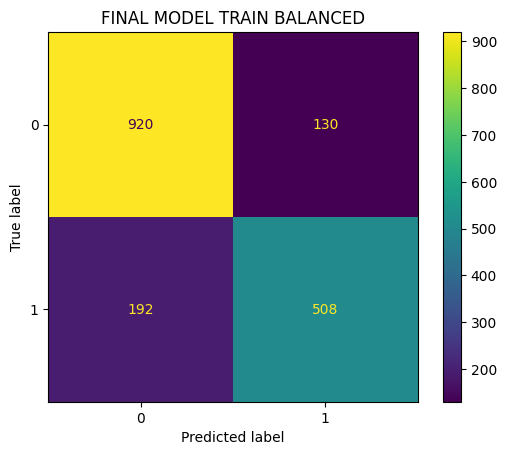

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7627906976744186
FINAL MODEL BALANCED Precision: 0.7464788732394366
FINAL MODEL BALANCED Recall: 0.6162790697674418
FINAL MODEL BALANCED Specificity: 0.8604651162790697
FINAL MODEL BALANCED F1 Score: 0.6751592356687898


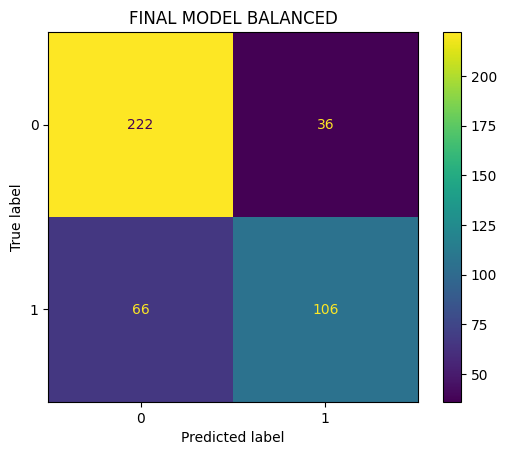

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.800222593210907
FINAL MODEL IMBALANCED Precision: 0.2656641604010025
FINAL MODEL IMBALANCED Recall: 0.6162790697674418
FINAL MODEL IMBALANCED Specificity: 0.8196923076923077
FINAL MODEL IMBALANCED F1 Score: 0.3712784588441331


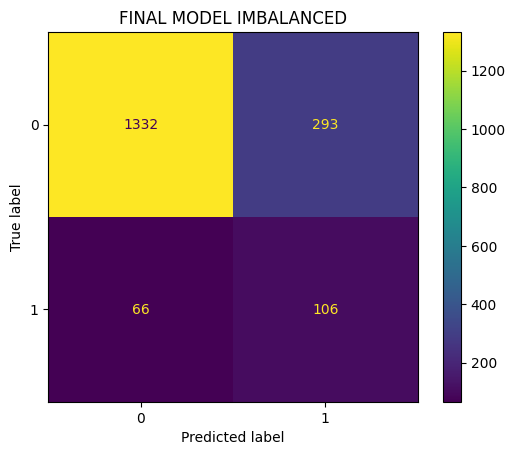

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7348837209302326
FINAL MODEL BALANCED Precision: 0.6526315789473685
FINAL MODEL BALANCED Recall: 0.7209302325581395
FINAL MODEL BALANCED Specificity: 0.7441860465116279
FINAL MODEL BALANCED F1 Score: 0.6850828729281767


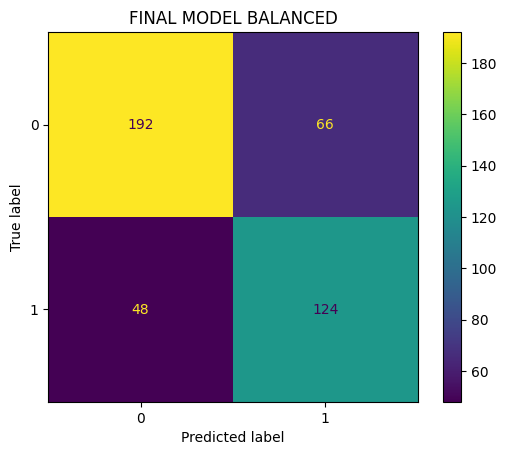

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7323316638842515
FINAL MODEL IMBALANCED Precision: 0.22262118491921004
FINAL MODEL IMBALANCED Recall: 0.7209302325581395
FINAL MODEL IMBALANCED Specificity: 0.7335384615384616
FINAL MODEL IMBALANCED F1 Score: 0.3401920438957476


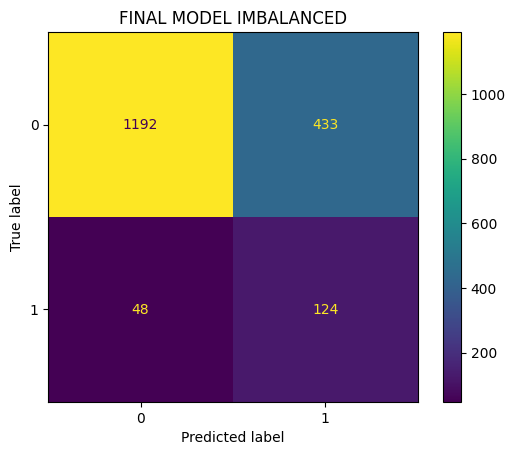

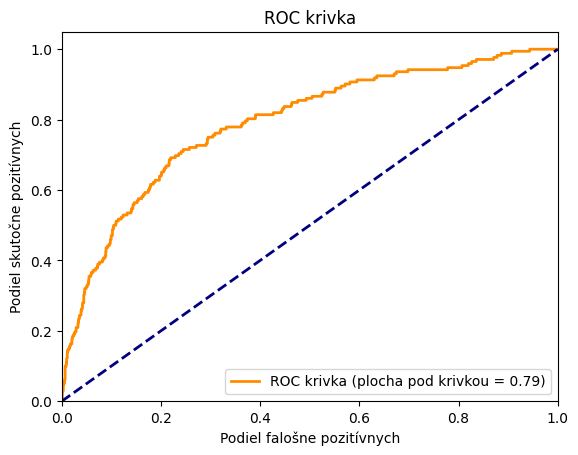

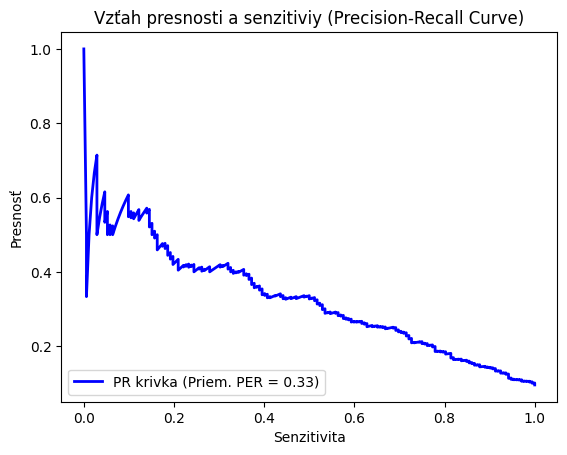

In [ ]:
rf_final = (RandomForestClassifier(
    random_state=42,
    max_depth=  30,
    max_features= 'log2',
    min_samples_leaf= 2,
    min_samples_split= 50,
    n_estimators= 50))


rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_test_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

